In [5]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

In [6]:
import os

from dotenv import load_dotenv

load_dotenv()

# automatically reload all modules before executing new code. The captures changes in local packages.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from typing import Annotated, List, Literal, Union

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


@tool
def calculator(
    operation: Literal["add", "subtract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float]
) -> Union[int, float]:
    """Define a two-input calculator tool that returns precise answers.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.
        
    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Divizion by zero is not allowed."}
    

    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"
    return result

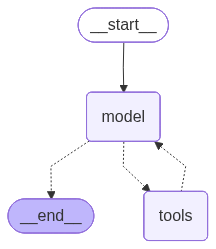

In [8]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.agents import create_agent 
from utils import format_messages

SYSTEM_PROMPT = """
You are a helpful arithmetic assistant who is an expert at using a calculator. 
Return all text as plain text without Markdown math delimiters.
"""

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
    raise EnvironmentError("Установите OPENROUTER_API_KEY в файле .env")


llm = ChatOpenAI(
    model="deepseek/deepseek-v3.2",
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)

tools = [calculator]

agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=SYSTEM_PROMPT
).with_config({"recursion_limit":20})

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
type(agent)

langgraph.graph.state.CompiledStateGraph

In [10]:
# Example usage
result1 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

format_messages(result1["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll calculate 3.1 multiplied by 4.2 for you.                                                                   │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: call_00_FKyTmunPlxhRh5KdisMlK0BW                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2 = 13.02                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
# Try your own 
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is ...?",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is ...?                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'm sorry, but your question seems incomplete. Could you please specify what you'd like to calculate? For       │
│ example, you could ask "What is 5 + 3?" or "What is 12 divided by 4?"                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
from IPython.display import JSON
from langchain_core.messages import messages_to_dict

JSON({"messages": messages_to_dict(result1["messages"])})

<IPython.core.display.JSON object>

In [13]:
from langchain.agents import AgentState


def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.
    
    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class CalcState(AgentState):
    """Graph State."""
    ops: Annotated[List[str], reduce_list]

In [14]:
@tool
def calculator_wstate(
    operation: Literal["add", "substract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Union[int, float]:
    """Define a two-input calculator tool.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.
        
    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == "divide" and b == 0:
        return {"error": "Division by zero is not allowed"}
    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"
    ops = [f"({operation}, {a}, {b})," ]
    return Command(
        update={
            "ops": ops,
            "messages": [
                ToolMessage(f"{result}", tool_call_id=tool_call_id)
            ],
        }
    )


In [15]:
SYSTEM_PROMPT = """
You are a helpful arithmetic assistant who is an expert at using a calculator. 
Return all text as plain text without Markdown math delimiters.
"""

agent = create_agent(
    model=llm,
    tools = [calculator_wstate],
    system_prompt=SYSTEM_PROMPT,
    state_schema=CalcState
).with_config({"recursion_limit": 20})

In [16]:
# Example usage
result2 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

format_messages(result2["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll calculate 3.1 multiplied by 4.2 for you.                                                                   │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: call_e281245614fd4ae597b85367                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2 = 13.02                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [17]:
# Example usage
result3 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2 + 5.5 * 6.5?",
            }
        ],
    }
)

format_messages(result3["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2 + 5.5 * 6.5?                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll calculate this step by step using the calculator.                                                          │
│                                                                                                                 │
│ First, let's calculate 3.1 * 4.2:                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: 019beb5927a0e7b0ec5935f8fb8310f9                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now, let's calculate 5.5 * 6.5:                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 5.5,                                                                                                     │
│   "b": 6.5                                                                                                      │
│ }                                                                                                               │
│    ID: call_9d05c69d02b44b7c9ec70009                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 35.75                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now, let's add these two results together:                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "a": 13.020000000000001,                                                                                      │
│   "b": 35.75                                                                                                    │
│ }                                                                                                               │
│    ID: call_517f9acda4b34d548eba79d0                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 48.77                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The result of 3.1 * 4.2 + 5.5 * 6.5 is 48.77.                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯